<a href="https://colab.research.google.com/github/varunkr24/Coputer-Vision/blob/Python/Recognize%2Bsimilar%2Bfaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective

**Use  a  pre-trained  model  trained  on  Face  recognition  to  recognise  similar  faces**

**Build distance metrics for identifying distance between two images**

**Use PCA for dimesionality reduction**

**Build an SVM classifier to map each image to its right person**

**Predict using the SVM model.VIDEO FILEDynamic Bounding box imputed over a live video**

# Load libraries and data

In [ ]:
import tensorflow
from tensorflow.keras.applications.mobilenet import MobileNet,preprocess_input
from tensorflow.keras.layers import Conv2D,MaxPooling2D,UpSampling2D,Reshape,Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,f1_score

In [ ]:
import os
os.getcwd()

'C:\\Users\\yadavv'

In [ ]:
os.chdir('C:\\Users\\yadavv\\varun\\python_cwd')

In [ ]:
from zipfile import ZipFile
with ZipFile('PINS.zip',mode = 'r') as z:
    try:
        z.extractall()
    except Exception as e:
        print(e)

# Function to identify and load metadata

In [ ]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')

In [ ]:
metadata[1].image_path()

'PINS\\pins_Aaron Paul\\Aaron Paul101_247.jpg'

In [ ]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [ ]:
# Load an image
# for example, loading the image with index 1
load_image(metadata[0].image_path())

array([[[233, 188, 165],
        [231, 186, 163],
        [220, 178, 156],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       [[232, 187, 164],
        [233, 188, 165],
        [220, 178, 156],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       [[230, 186, 161],
        [228, 184, 159],
        [206, 164, 140],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       ...,

       [[198, 118,  91],
        [197, 120,  94],
        [195, 119,  95],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]],

       [[200, 120,  93],
        [200, 120,  93],
        [198, 121,  95],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]],

       [[201, 121,  94],
        [201, 121,  94],
        [199, 122,  96],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]]

# Build Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

# Load pretrained model

In [ ]:
from tensorflow.keras.models import model_from_json
model = vgg_face()
model.load_weights('vgg_face_weights.h5')

In [ ]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [ ]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


# Get embeddings from images

In [ ]:
embeddings = np.zeros((metadata.shape[0], 2622))

for i, m in enumerate(metadata):
    try:
        img = load_image(m.image_path())
        # scale RGB values to interval [0,1]
        img = cv2.resize(img, dsize = (224,224))
        img = (img / 255.).astype(np.float32)
        # obtain embedding vector for image
        embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    except Exception as e:
        print(str(e))
        print(i,m)

# Eucledean Distnace fucntion

In [ ]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

# Show the distance between the two given images

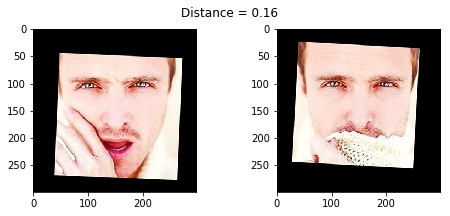

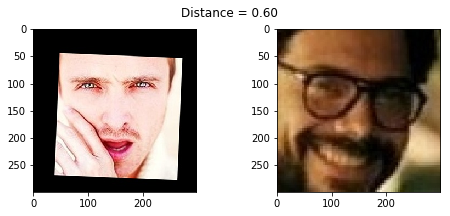

In [ ]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()))
    plt.show();    

show_pair(2, 3)
show_pair(2, 103)

# Build SVC Model using PCA

**Test train split**

In [ ]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities
X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
y_train = targets[train_idx]
y_test = targets[test_idx]

**Label Encoding**

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# Numerical encoding of identities
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

**Standardization**

In [ ]:
# Standarize features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

**Apply PCA**

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128, svd_solver='randomized', whiten=True)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

**SVC Model**

In [ ]:
from sklearn.svm import SVC

clf = SVC(kernel='rbf', class_weight=None , C=10000000, gamma='auto')
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9753593429158111

**Predict image using SVC Model**

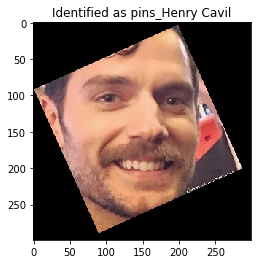

In [ ]:
import warnings
warnings.filterwarnings('ignore')

example_idx = 289

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = clf.predict([X_test[example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}')
plt.show();